In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import ANALYSIS
from architecture import ARCHITECTURE
import architecture

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate, Layer
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, LSTM, CuDNNLSTM

import keras.backend as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EXP = 'CD100T10'

obj = ANALYSIS(EXP)
arch_obj = ARCHITECTURE()

Using TensorFlow backend.


In [2]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')

drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length = 1000
pad_target = pad_sequences(encode_target, maxlen=max_length, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length, padding='post', truncating='post')

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [3]:
# Define architecture
input_target, att_out_target = arch_obj.protSeq(1000)
input_drug, att_out_drug = arch_obj.drugSeq(1000)
#input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

concat = Concatenate()([att_out_target,att_out_drug])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
#dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2_dropout = Dropout(0.4)(dense_2)

x_output = Dense(3, activation='softmax')(dense_2_dropout)

# Bulid and compile model
model = Model(inputs=[input_target, input_drug], outputs=x_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model1.summary()

In [4]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, y_train, y_test = train_test_split(pad_target, pad_drug, y, test_size=0.2, random_state=20)

print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [5]:
# Early Stopping & checkpoint
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
filepath='checkpoints/'+EXP+'/improvement_'+EXP+'.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(
    [train_target, train_drug], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es, model_checkpoint, reduce_lr_loss]
    )

: 0.6999

Epoch 00273: val_loss improved from 0.71447 to 0.71357, saving model to checkpoints/CD100T10/improvement_CD100T10.hdf5
Epoch 274/500
39439/39439 [==============================] - 18s 460us/step - loss: 0.6304 - accuracy: 0.7378 - val_loss: 0.7145 - val_accuracy: 0.6994

Epoch 00274: val_loss did not improve from 0.71357
Epoch 275/500
39439/39439 [==============================] - 18s 461us/step - loss: 0.6310 - accuracy: 0.7361 - val_loss: 0.7154 - val_accuracy: 0.6973

Epoch 00275: val_loss did not improve from 0.71357
Epoch 276/500
39439/39439 [==============================] - 18s 460us/step - loss: 0.6314 - accuracy: 0.7348 - val_loss: 0.7148 - val_accuracy: 0.7012

Epoch 00276: val_loss did not improve from 0.71357
Epoch 277/500
39439/39439 [==============================] - 18s 460us/step - loss: 0.6318 - accuracy: 0.7355 - val_loss: 0.7134 - val_accuracy: 0.6999

Epoch 00277: val_loss improved from 0.71357 to 0.71336, saving model to checkpoints/CD100T10/improvement_C

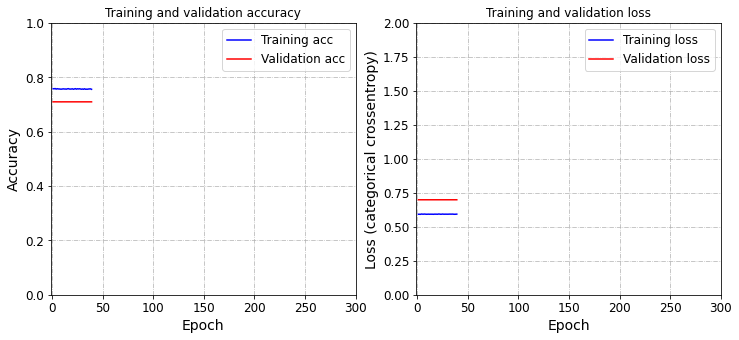

In [11]:
obj.plotTrainingPerf(history, save=False)

In [7]:
# Sve model weights
model.save_weights('my_model_weights.h5')

In [8]:
# Load saved model
saved_model1 = keras.models.load_model('checkpoints/'+EXP+'/improvement_'+EXP+'.hdf5', custom_objects={'attention': architecture.attention()})

In [9]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model1, y_test, a = test_target, b = test_drug)
precision, recall, average_precision = obj.aupr(saved_model1, y_test, a = test_target, b = test_drug)

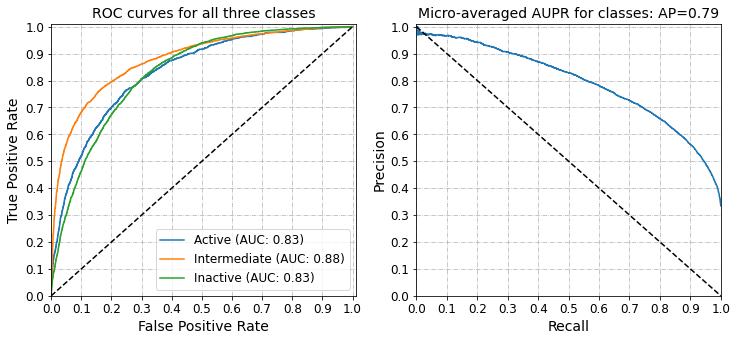

In [10]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, save=False)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate([test_pad_target, test_pad_drug], y_test, batch_size=256)
print("test loss, test acc:", results)